In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

from tqdm.notebook import tqdm

from custom_metrics import calculate_modularity, interpolation_quality
from graph_generator import generate_time_series, generate_random_mu
from interpolation import interpolate_time_series

from custom_modularity import custom_modularity

**Генерация двух темпоральных сетей**

У одной сети модулярность будет меняться монотонно во времени, у другой - немонотонно

In [ ]:
n_snaps = 31
mu_range_mon = np.linspace(0.25, 0.6, n_snaps)
time_range = list(range(n_snaps))

graphs_mon = generate_time_series(mu_range_mon)
print('[INFO] ', datetime.now().strftime("%Y-%m-%d %H:%M:%S"), f'{n_snaps} graphs were generated')

modularities_mon = [custom_modularity(G) for G in graphs_mon]
print('[INFO] ', datetime.now().strftime("%Y-%m-%d %H:%M:%S"), f'modularities were calculated')

[INFO]  2022-06-19 17:59:46 31 graphs were generated
[INFO]  2022-06-19 17:59:47 modularities were calculated


In [ ]:
mu_range_ran = [0.36842123, 0.35397016, 0.33951909, 0.32506801, 0.32066094,
       0.38656187, 0.45246281, 0.51836374, 0.55825175, 0.52010096,
       0.48195017, 0.44379938, 0.41922152, 0.41726521, 0.41530891,
       0.4133526 , 0.39663945, 0.36516945, 0.33369946, 0.30222947,
       0.3385115 , 0.41544475, 0.49237799, 0.56931124, 0.54446379,
       0.48568943, 0.42691507, 0.36814071, 0.38380492, 0.41010321,
       0.43640151]
       
graphs_ran = generate_time_series(mu_range_ran)
print('[INFO] ', datetime.now().strftime("%Y-%m-%d %H:%M:%S"), f'{n_snaps} graphs were generated')

modularities_ran = [custom_modularity(G) for G in graphs_ran]
print('[INFO] ', datetime.now().strftime("%Y-%m-%d %H:%M:%S"), f'modularities were calculated')

[INFO]  2022-06-19 17:59:49 31 graphs were generated
[INFO]  2022-06-19 17:59:50 modularities were calculated


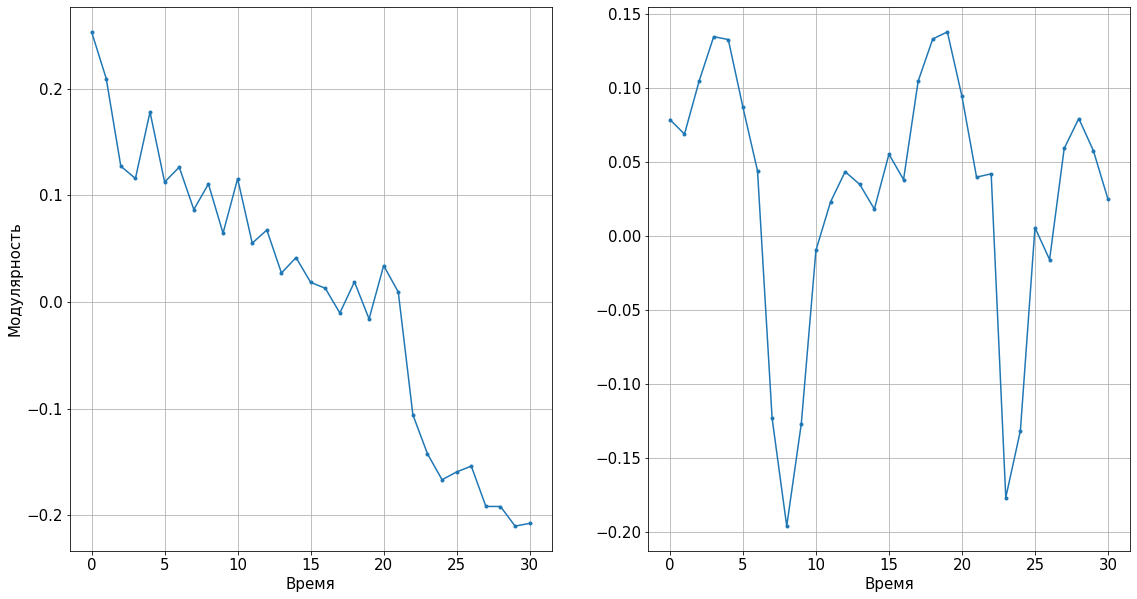

In [ ]:
plt.rcParams['figure.figsize'] = [19, 10]
plt.rcParams['font.size'] = 15

fig, axs = plt.subplots(1, 2)
for i, modularities in enumerate([modularities_mon, modularities_ran]):
    if i == 0:
        axs[i].set_ylabel('Модулярность')
    axs[i].grid()
    axs[i].set_xlabel('Время')
    axs[i].plot(time_range, modularities, marker='.')

**Тестирование алгоритма интерполяции для сети с монотонной модулярностью**

Исключим из сгенерированной сети неколько снапов, выбирая разный шаг интерполяции (шаг 2 означает, что останется только каждый второй граф, шаг 4 - что только каждый четвертный и т.д.). Затем интерполяцией найдем исключенные графы и сравним их модулярность с настоящими

In [ ]:
def run_experiments(graphs, modularities):
    interpolation_steps = [2, 4, 6]

    interpolated_graphs = {}
    new_modularities = {}
    quality = {}
    for interpolation_step in interpolation_steps:
        old_time_range = time_range[0::interpolation_step]
        old_graphs = graphs[0::interpolation_step]

        interpolated_graphs[interpolation_step] = interpolate_time_series(old_time_range, old_graphs, time_range)

        new_modularities[interpolation_step] = [custom_modularity(G) for G in interpolated_graphs[interpolation_step]]
        quality[interpolation_step] = interpolation_quality(modularities, new_modularities[interpolation_step])
    
    fig, axs = plt.subplots(1, 3)

    for i, interpolation_step in enumerate([2, 4, 6]):
        if i == 0:
            axs[i].set_ylabel('modularity')
        axs[i].set_title(f'Interpolation step = {interpolation_step}')
        axs[i].set_xlabel('time')
        axs[i].plot([], [], ' ', label=f'Error rate = {np.round(quality[interpolation_step], 2)}')
        axs[i].plot(time_range, modularities, marker='.', label='Ground truth')
        axs[i].plot(time_range, new_modularities[interpolation_step], marker='.', label='Interpolation')
        axs[i].legend()

    return pd.DataFrame({'interpolation_step': interpolation_steps, 'quality': quality.values()})

,interpolation_step,quality
0,2,0.143200
1,4,0.137430
2,6,0.170902


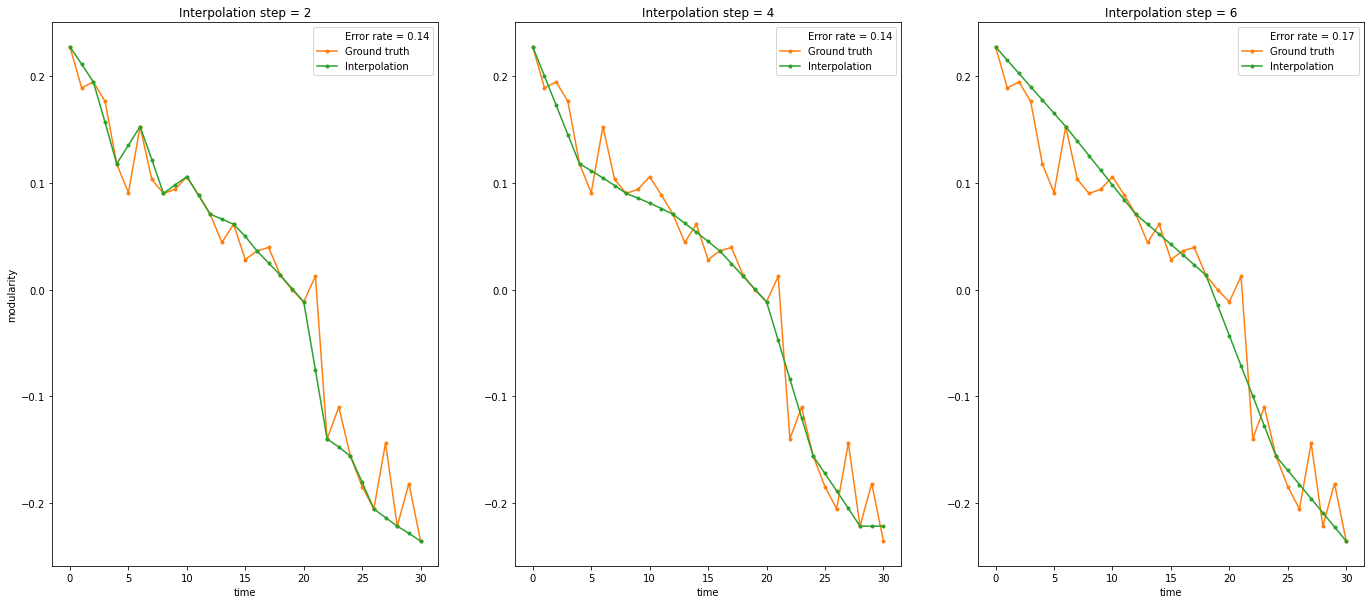

In [ ]:
plt.rcParams['figure.figsize'] = [23.5, 10]
quality = run_experiments(graphs_mon, modularities_mon)
quality

**Тестирование алгоритма интерполяции для сети с немонотонной модулярностью**

Повторим эксперимент для второй сети

,interpolation_step,quality
0,2,0.188023
1,4,0.249156
2,6,0.451901


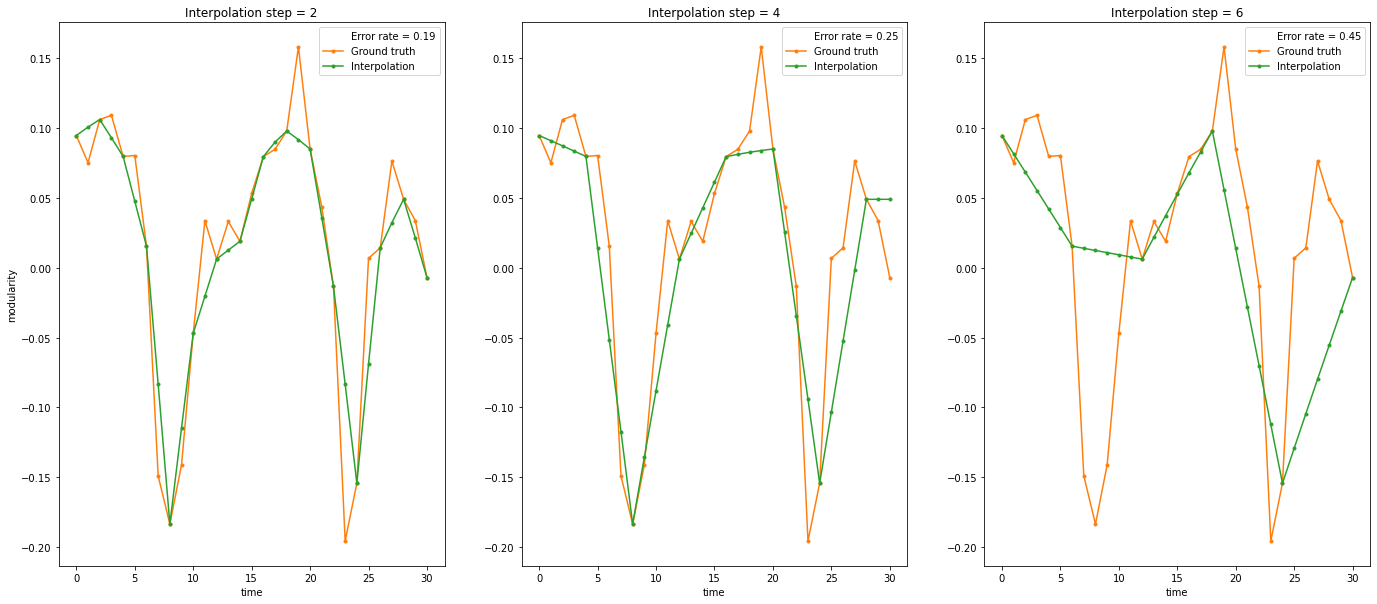

In [ ]:
quality = run_experiments(graphs_ran, modularities_ran)
quality

**Вычисление дифференциальной эволюции между соседними шагами по времени**

Для каждого графа, найденного интерполяцией, проверим, что его модулярность действительно складывается из линейной комбинации модулярностей соседних графов и дифференциальной модулярности:

$$Q_{est} = \alpha Q_{t+1} + (1-\alpha)Q_{t-1} + Q_{diff}$$

In [ ]:
from custom_modularity import calculate_differential_modularity

In [ ]:
old_time_range = time_range[0::2]
old_graphs = graphs_mon[0::2]

interpolated_graphs = interpolate_time_series(old_time_range, old_graphs, time_range)

new_modularities = [custom_modularity(G) for G in interpolated_graphs]

In [ ]:
for i in range(0, n_snaps-1, 2):
    alpha = 0.5

    G1 = interpolated_graphs[i]
    G = interpolated_graphs[i+1]
    G2 = interpolated_graphs[i+2]
    
    Q_diff = calculate_differential_modularity(G1, G2, alpha)

    Q1 = new_modularities[i]
    Q = new_modularities[i+1]
    Q2 = new_modularities[i+2]

    Q_est = (1-alpha)*Q1 + alpha*Q2 + Q_diff

    print(i, i+2)
    print('\t', f'DM: {Q_diff}')
    print('\t', f'Q_est - Q_real = ', abs(Q_est - Q))

0 2
	 DM: 0.00019227084475805612
	 Q_est - Q_real =  9.159339953157541e-16
2 4
	 DM: 0.00021015889307830093
	 Q_est - Q_real =  3.0531133177191805e-16
4 6
	 DM: 5.464065464031406e-05
	 Q_est - Q_real =  5.551115123125783e-17
6 8
	 DM: 2.7354123236145666e-05
	 Q_est - Q_real =  4.996003610813204e-16
8 10
	 DM: 6.479397449937544e-05
	 Q_est - Q_real =  1.249000902703301e-16
10 12
	 DM: 1.0223805626610355e-05
	 Q_est - Q_real =  6.938893903907228e-17
12 14
	 DM: 0.0005109128531752567
	 Q_est - Q_real =  2.1163626406917047e-16
14 16
	 DM: 7.210224488879677e-06
	 Q_est - Q_real =  3.122502256758253e-17
16 18
	 DM: 0.0004200536230570912
	 Q_est - Q_real =  9.367506770274758e-17
18 20
	 DM: 0.00026998646616654964
	 Q_est - Q_real =  0.0
20 22
	 DM: 6.564455825426376e-05
	 Q_est - Q_real =  3.3306690738754696e-16
22 24
	 DM: 1.1613037594013342e-05
	 Q_est - Q_real =  1.942890293094024e-16
24 26
	 DM: 9.742526389416131e-07
	 Q_est - Q_real =  8.326672684688674e-17
26 28
	 DM: 8.251745486410234e